In [1]:
# Cargar Librerias Generales
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
import warnings

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.model_selection import train_test_split

from scipy.stats import skew

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold

from sklearn.model_selection import GridSearchCV

from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import GradientBoostingClassifier

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import RFE
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import classification_report, roc_curve, auc, mean_absolute_error
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.optimizers import Adam

# Carga de datos

In [2]:
# Cargar lista de insumos
dir = 'raw_data/'
file = 'files_list.csv'

file_df = pd.read_csv(dir + file, index_col='ind')

#Separar códigos bursátiles
pattern = r'\((.*?)\)'

file_df['stock'] = file_df['name'].str.extract(pattern)
file_df['name'] = file_df['name'].str.replace(pattern, '')

# Seleccionar el top de empresas a usar (siempre cargar negativos y 0)
top_n = 30

file_df = file_df[file_df.index < top_n + 1]
file_df

C:\Users\Carlos\AppData\Local\Temp\ipykernel_8844\2252273142.py:11: FutureWarning: The default value of regex will change from True to False in a future version.
  file_df['name'] = file_df['name'].str.replace(pattern, '')


,name,stock
ind,,
-2,FEDFUNDS,FEDFUNDS
-1,UNRATE,UNRATE
0,NASDAQ 100,^NDX
1,Apple Inc.,AAPL
2,Microsoft Corporation,MSFT
3,"Amazon.com, Inc.",AMZN
4,NVIDIA Corporation,NVDA
5,"Meta Platforms, Inc.",META
6,Broadcom Inc.,AVGO


In [3]:
# Cargar archivos en dataframe y gardarlos en diccionario
stocks_dict = {}

for f in file_df['stock']:
    file = f + '.csv'
    df_name = f + '_DF'
    df = pd.read_csv(dir + file)
    stocks_dict[df_name] = df

stocks_dict.keys()

dict_keys(['FEDFUNDS_DF', 'UNRATE_DF', '^NDX_DF', 'AAPL_DF', 'MSFT_DF', 'AMZN_DF', 'NVDA_DF', 'META_DF', 'AVGO_DF', 'TSLA_DF', 'GOOG_DF', 'GOOGL_DF', 'ADBE_DF', 'PEP_DF', 'COST_DF', 'CSCO_DF', 'CMCSA_DF', 'NFLX_DF', 'AMD_DF', 'TMUS_DF', 'TXN_DF', 'INTU_DF', 'INTC_DF', 'AMGN_DF', 'AMAT_DF', 'QCOM_DF', 'HON_DF', 'BKNG_DF', 'SBUX_DF', 'ISRG_DF', 'ADP_DF', 'MDLZ_DF', 'GILD_DF'])

# Preprocesado de datos

In [4]:
# Parsear formato de fechas para FEDFUNDS y UNRATE
macros = ['FEDFUNDS_DF', 'UNRATE_DF']
stocks = [key for key in stocks_dict.keys() if key not in macros]

for i in macros:
    stocks_dict[i]['DATE'] = pd.to_datetime(stocks_dict[i]['DATE'], format='%d/%m/%Y')
    stocks_dict[i]['DATE'] = stocks_dict[i]['DATE'].dt.strftime('%Y-%m-%d')

    # Cambiar nombre de columna a Date
    stocks_dict[i].rename(columns= {'DATE' : 'Date'}, inplace= True)

In [5]:
# Visualización de los dataframe
stocks_dict['FEDFUNDS_DF']

,Date,FEDFUNDS
0,1954-07-01,0.80
1,1954-08-01,1.22
2,1954-09-01,1.07
3,1954-10-01,0.85
4,1954-11-01,0.83
...,...,...
829,2023-08-01,5.33
830,2023-09-01,5.33
831,2023-10-01,5.33
832,2023-11-01,5.33


In [6]:
# Seleccionar variables que nos interesan y eliminar las demas de los DF
variables = ['Date', 'FEDFUNDS', 'UNRATE', 'High', 'Low', 'Open', 'Close', 'Volume']

for df in stocks_dict.keys():
    for col in stocks_dict[df].columns:
        if col not in variables:
            stocks_dict[df].drop(col, axis= 1, inplace= True)

stocks_dict['AAPL_DF'].columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Volume'], dtype='object')

In [7]:
# Definimos fechas inicio y fin, eliminaremos todo lo que no esté en este rango
start_date= '2012-06-01'           #  Meta 2012-06-01
end_date= '2023-12-31'
date_range = pd.date_range(start=start_date, end= end_date, freq= 'D')

for df in stocks_dict.keys():
    stocks_dict[df].drop(stocks_dict[df][stocks_dict[df]['Date'] < start_date].index, inplace=True)
    stocks_dict[df].drop(stocks_dict[df][stocks_dict[df]['Date'] > end_date].index, inplace=True)

stocks_dict['FEDFUNDS_DF']

,Date,FEDFUNDS
695,2012-06-01,0.16
696,2012-07-01,0.16
697,2012-08-01,0.13
698,2012-09-01,0.14
699,2012-10-01,0.16
...,...,...
829,2023-08-01,5.33
830,2023-09-01,5.33
831,2023-10-01,5.33
832,2023-11-01,5.33


# Análisis exploratorio de datos (Exploratory Data Analysis)

**El siguiente código tiene como objetivo detectar valores nulos o duplicados en distintos conjuntos de datos.**

In [8]:
# Visualizar información de cada DF y alertar por nulos y duplicados
for df in stocks_dict.keys():
    print('***** '+ df +' *****')
    stocks_dict[df].info()

    null_values = stocks_dict[df].isnull().any()
    if null_values.any():
        print("Advertencia: " + df + " contiene nulos!!")

    duplicated_rows = stocks_dict[df].duplicated()
    if duplicated_rows.any():
        print("Advertencia: " + df + " contiene duplicados!!")

    print()
    print()

***** FEDFUNDS_DF *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 695 to 833
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Date      139 non-null    object 
 1   FEDFUNDS  139 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.3+ KB


***** UNRATE_DF *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 773 to 911
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    139 non-null    object 
 1   UNRATE  139 non-null    float64
dtypes: float64(1), object(1)
memory usage: 2.3+ KB


***** ^NDX_DF *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2914 entries, 6726 to 9639
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2914 non-null   object 
 1   Open    2914 non-null   float64
 2   High    2914 non-null   float64
 3   Low     291



***** HON_DF *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2914 entries, 12692 to 15605
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2914 non-null   object 
 1   Open    2914 non-null   float64
 2   High    2914 non-null   float64
 3   Low     2914 non-null   float64
 4   Close   2914 non-null   float64
 5   Volume  2914 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 136.7+ KB


***** BKNG_DF *****
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2914 entries, 3315 to 6228
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Date    2914 non-null   object 
 1   Open    2914 non-null   float64
 2   High    2914 non-null   float64
 3   Low     2914 non-null   float64
 4   Close   2914 non-null   float64
 5   Volume  2914 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 136.7+ KB


***** SBUX_DF *

Según los resultados obtenidos del código previo, podemos concluir que no hay valores duplicados ni nulos de forma individual en cada dataframe. Sin embargo, como la información de tasas son series mensuales, bimestrales o trimestrales, es necesario convertirlas en series diarias, donde cada valor diario corresponderá al último valor mensual conocido.

Lo anterior hay que realizarlo porque posteriormente quitaremos las filas que tengan nulos o NaN en alguna variable y nos estaríamos quedando con información correspondiente a 1 día del mes de no hacer esta imputación

In [9]:
# Convertimos las fechas de nuestras variables a un tipo fecha en lugar de objeto
for i in macros:
    stocks_dict[i]['Date'] = pd.to_datetime(stocks_dict[i]['Date'])

# Para cada variable macroeconómica
for m in stocks_dict.keys():
    if m in macros:
        # Generamos un DF vacío que incluye todo el rango de fechas
        temp = pd.DataFrame()
        temp['Date'] = pd.to_datetime(date_range)

        # Unimos el nuevo dataframe con el de la macroeconómica existente
        temp = temp.merge(stocks_dict[m], on= 'Date', how= 'left')

        # Imputamos el último valor conocido
        temp.iloc[:,1] = temp.iloc[:,1].fillna(method='ffill')

        # Reemplazamos el dataframe existente por el nuevo
        stocks_dict[m] = temp

stocks_dict['FEDFUNDS_DF']

,Date,FEDFUNDS
0,2012-06-01,0.16
1,2012-06-02,0.16
2,2012-06-03,0.16
3,2012-06-04,0.16
4,2012-06-05,0.16
...,...,...
4226,2023-12-27,5.33
4227,2023-12-28,5.33
4228,2023-12-29,5.33
4229,2023-12-30,5.33


**A continuación, presentamos un resumen de las características del conjunto de datos.**

In [10]:
for df in stocks_dict.keys():
    print('***** '+ df +' *****')
    print(stocks_dict[df].describe())
    print()
    print()

***** FEDFUNDS_DF *****
          FEDFUNDS
count  4231.000000
mean      1.120069
std       1.485767
min       0.050000
25%       0.090000
50%       0.360000
75%       1.700000
max       5.330000


***** UNRATE_DF *****
            UNRATE
count  4231.000000
mean      5.260671
std       1.888745
min       3.400000
25%       3.800000
50%       4.800000
75%       6.200000
max      14.800000


***** ^NDX_DF *****
               Open          High           Low         Close        Volume
count   2914.000000   2914.000000   2914.000000   2914.000000  2.914000e+03
mean    7727.255158   7782.537187   7668.648797   7729.470973  2.923642e+09
std     4202.526633   4238.562810   4163.927109   4203.448103  1.517643e+09
min     2458.969971   2480.969971   2443.919922   2458.830078  2.441200e+08
25%     4297.375000   4324.500000   4273.190064   4296.544800  1.817850e+09
50%     6636.185059   6692.505127   6578.689942   6643.979980  2.141175e+09
75%    11633.947266  11764.110107  11529.650391  11675.1

              Open         High          Low        Close        Volume
count  2914.000000  2914.000000  2914.000000  2914.000000  2.914000e+03
mean     37.694931    38.465233    36.906352    37.700027  5.082053e+07
std      41.564722    42.402870    40.693748    41.564032  3.700052e+07
min       1.620000     1.690000     1.610000     1.620000  0.000000e+00
25%       3.830000     3.900000     3.772500     3.830000  2.199885e+07
50%      13.720000    13.930000    13.435000    13.710000  4.426585e+07
75%      77.565001    78.807499    75.992500    77.509998  6.867305e+07
max     163.279999   164.460007   156.100006   161.910004  3.250584e+08


***** TMUS_DF *****
              Open         High          Low        Close        Volume
count  2914.000000  2914.000000  2914.000000  2914.000000  2.914000e+03
mean     73.965199    74.750916    73.161108    73.981486  4.550196e+06
std      43.362482    43.729260    42.972752    43.357623  3.712174e+06
min      11.240000    11.560000    11.0600

**Ahora se están graficando las variables con el objetivo de identificar posibles valores atípicos.**

In [11]:
# # Graficaremos cada variable
# num_ticks = 10

# for df in stocks_dict.keys():
#     if df in macros:
#         fig, ax = plt.subplots()

#         ax.plot(stocks_dict[df]['Date'],stocks_dict[df].iloc[:,1], linestyle= '-', color='b')

#         fig.autofmt_xdate()
#         plt.xticks(stocks_dict[df]['Date'][::len(stocks_dict[df]['Date']) // num_ticks])

#         plt.title(df)
#         plt.xlabel(stocks_dict[df].columns[0])
#         plt.ylabel(stocks_dict[df].columns[1])

#     if df in stocks:
#         fig, ax = plt.subplots()

#         ax.plot(stocks_dict[df]['Date'],stocks_dict[df].iloc[:,1], label= 'Open Price', linestyle= '-', color='b')
#         #ax.plot(stocks_dict[df]['Date'],stocks_dict[df].iloc[:,2], label= 'Close Price', linestyle= '--', color='r')

#         fig.autofmt_xdate()
#         plt.xticks(stocks_dict[df]['Date'][::len(stocks_dict[df]['Date']) // num_ticks])

#         plt.title(df)
#         plt.xlabel(stocks_dict[df].columns[0])
#         plt.ylabel(stocks_dict[df].columns[1] + ' Price')

# plt.show()

Las gráficas anteriores indican que no existen valores atípicos en la variable seleccionada.

**Análisis de cardinalidad.**

Si buscamos determinar la cardinalidad de las variables, podemos afirmar que no hay variables categóricas para analizar. Sin embargo, incluso al intentar analizar la cardinalidad de las variables no categóricas, podemos utilizar las gráficas anteriores para observar que varía de manera diferente en cada empresa, pero en general tiende a ser alta cuando consideramos un plazo de tiempo también extenso.

**Tendencias temporales**

Con base en las gráficas anteriores, también es posible identificar tendencias temporales, las cuales son comunes en este tipo de variables a lo largo del tiempo. Se observa que prácticamente todas las empresas muestran tendencias temporales, como el ejemplo de Amazon, donde se aprecia un crecimiento significativo durante el 2020 y una estabilidad relativa hasta el 2022.

**A continuación, realizaremos un análisis de distribución para cada variable numérica de los dataframes. Este análisis nos permitirá identificar si las variables tienen una distribución normal o si están sesgadas.**

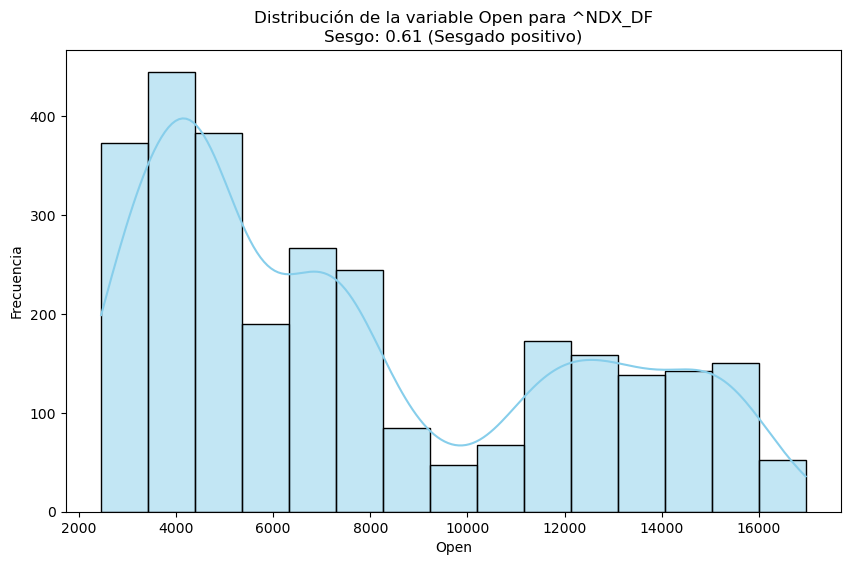

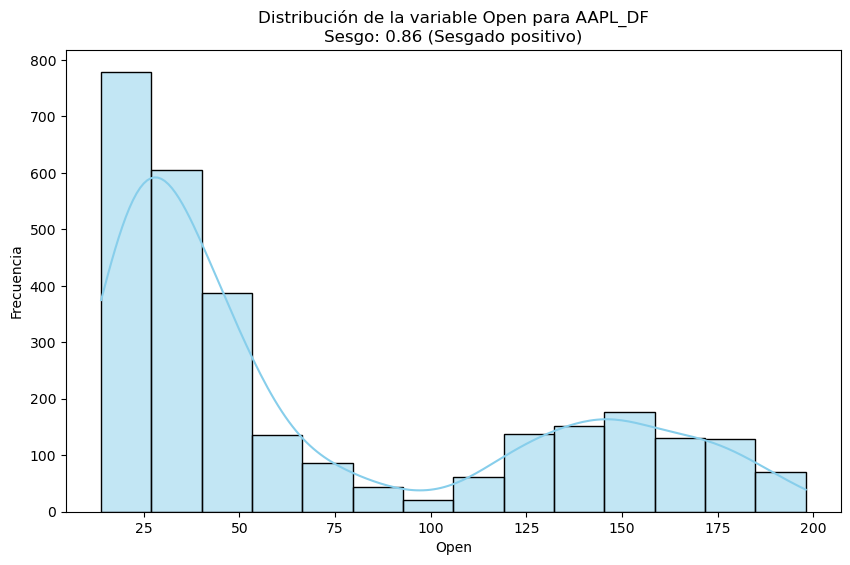

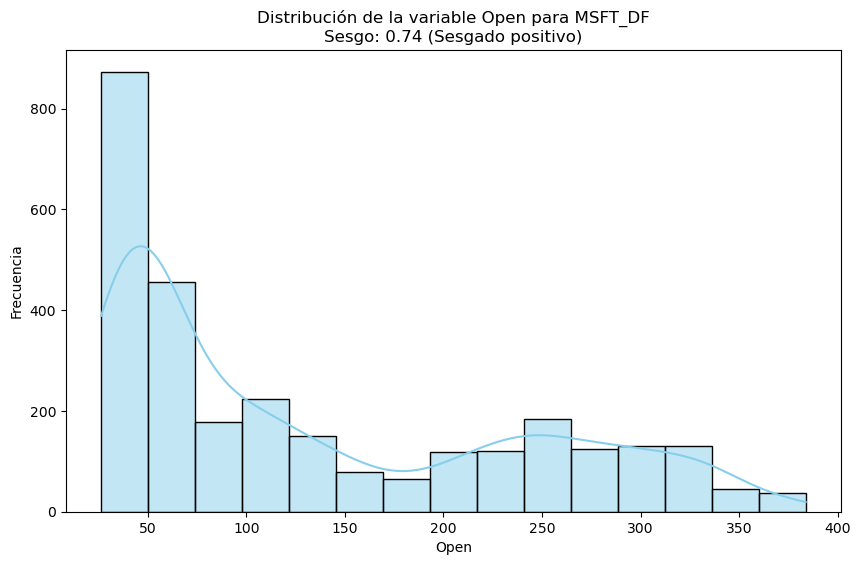

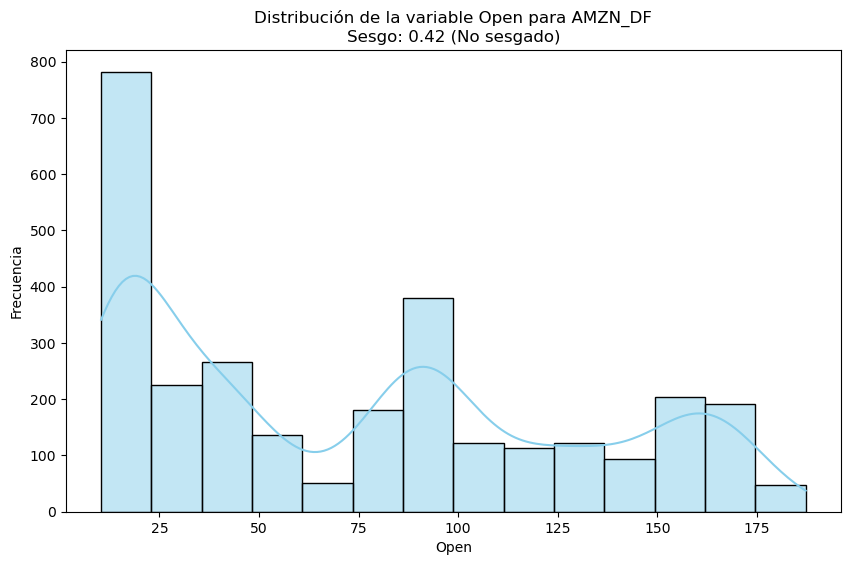

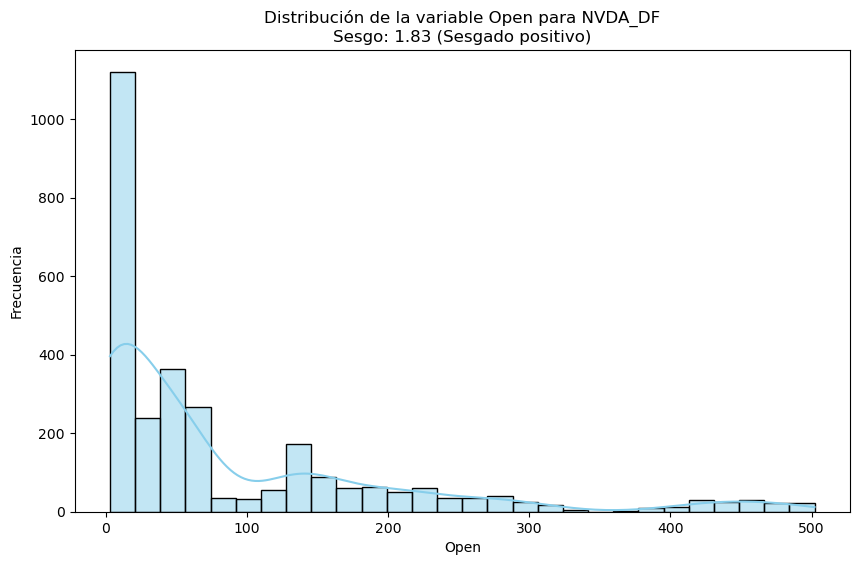

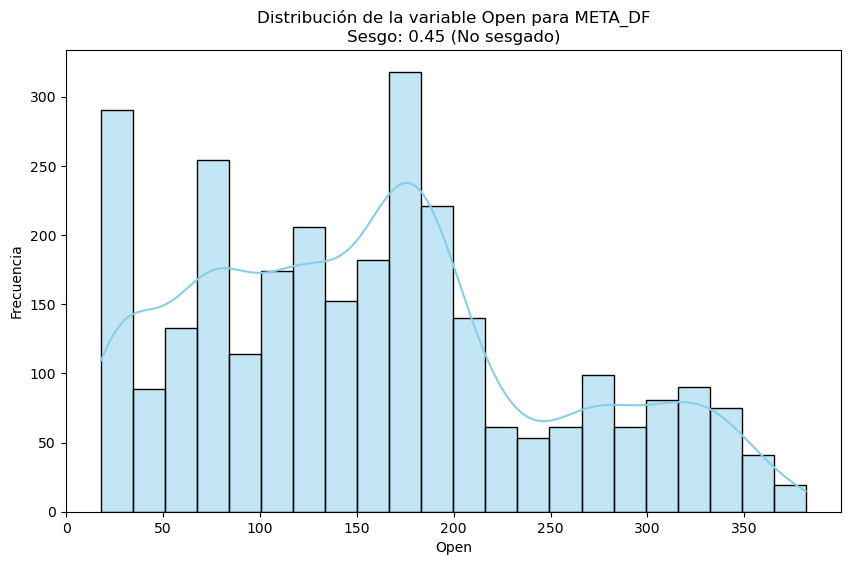

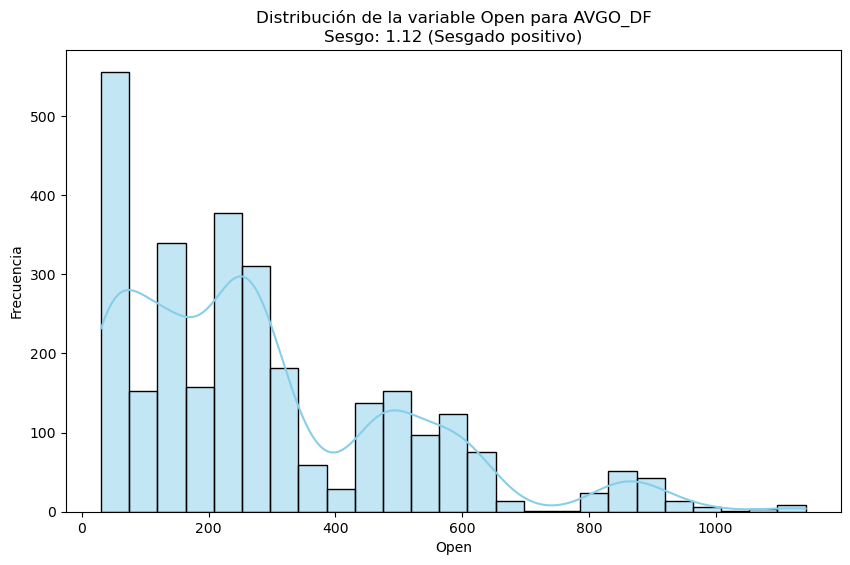

In [ ]:
for df in stocks_dict.keys():
  if df in stocks:

    sesgo = skew(stocks_dict[df]['Open'])

    if abs(sesgo) > 0.5:
        tipo_sesgo = "Sesgado positivo"
    elif abs(sesgo) < -0.5:
      tipo_sesgo = "Sesgado negativo"
    else:
        tipo_sesgo = "No sesgado"

    plt.figure(figsize=(10, 6))
    sns.histplot(stocks_dict[df]['Open'], kde=True, color='skyblue')
    plt.title(f'Distribución de la variable Open para {df}\nSesgo: {sesgo:.2f} ({tipo_sesgo})')
    plt.xlabel('Open')
    plt.ylabel('Frecuencia')
    plt.show()



Analizando los resultados, observamos que la mayoría de las variables presentan un sesgo positivo, mientras que una minoría no muestra sesgo alguno.

Por el momento no estaremos realizando transformaciones no lineales a los datos, mas bien buscaremos primero implementar modelos que no usen este requisito, aunque no se descarta que en un futuro se regrese a explorar esta posibilidad para mejorar los modelos

**Análisis de las variables dependientes e independientes.**

A continuación se hará un análisis de correlación sobre las variables identificadas:

In [ ]:
# Convertimos las fechas de nuestras variables a un tipo fecha en lugar de objeto
for i in stocks:
    stocks_dict[i].iloc[:,0] = pd.to_datetime(stocks_dict[i].iloc[:,0])

# Para cada dataframe, asignamos como índice la columna de la fecha
for df in stocks_dict.keys():
#    if df in stocks:
        stocks_dict[df].set_index('Date', inplace= True)
        stocks_dict[df].columns = [f'{df}_{col}' for col in stocks_dict[df].columns]

stocks_dict['AAPL_DF']

In [ ]:
# Unimos los dataframes con la fecha como índice
#first_key = next(iter(stocks_dict))
#first_key

#for df in stocks_dict.keys():
#    if df == first_key:
#        merged_stocks = stocks_dict[df]
#    else:
#        merged_stocks = pd.merge(merged_stocks, stocks_dict[df], how='left', left_index=True, right_index=True)

#merged_stocks.set_index('Date', inplace= True)
#merged_stocks

In [ ]:
#Calculamos la correlación entre las variables
#plt.figure(figsize=(24,16))
#sns.heatmap(merged_stocks.corr(), cmap='coolwarm', linewidths = 1, annot=True, annot_kws={"fontsize":8})
#plt.show()

Como resultado del análisis se puede observar que las variables de volumen de operación son las que tienen menos correlación contra todas las demas, seguidas de las variables macroeconómicas de la tasa de interés y tasa de desempleo. Finalmente en rojo se aprecian que en general los precios de apertura y cierre de una misma acción tienen una alta correlación mientras también una correlación (un poco más debil) contra precios de otras acciones.

**Distribución de los datos por categorías.**

Al no disponer de variables categóricas, no es posible identificar distribuciones en los datos de manera convencional.

**Patrones o agrupaciones (clusters) de datos.**

La tendencia de los datos utilizados sugiere que no existen patrones o agrupaciones discernibles en este conjunto.

**Normalización de imágenes.**

Para este proyecto no es necesario el uso de imágenes.

**¿Hay desequilibrio en las clases de la variable objetivo?**

Por el momento no se ha definido formalmente una variable objetivo, se pretende realizar la predicción del ^NDX_DF_Open, que representa el precio de apertura del índice bursatil, en el presente análisis todavía se presenta como un valor numérico. Sin embargo en futuras entregas se pretende evaluar si es más conveniente convertirlo en una variable categórica que represente si al día t+1 aumentó o disminuyó su valor respecto al cierre del día t. Esto considerando el objetivo de tener una estrategia de inversión que nos permite identificar qué es más conveniente, si mantener el ETF o venderlo a final de día.

# Ingeniería de características (FE - Feature Engineering)

**Construcción**

Ahora incorporamos una nueva característica a cada conjunto de datos: la variación diaria entre la apertura y el cierre del mercado, con el objetivo de analizar y visualizar esta tendencia.

 La variación diaria entre la apertura y el cierre del mercado es una métrica relevante que puede enriquecer la información disponible para el modelo de predicción de acciones, ofreciendo una perspectiva más detallada sobre la dinámica diaria del mercado de valores.

In [ ]:
# A cada DF se le calculará su volatilidad diaria como la diferencia entre las columnas High y Low, dividiendo entre Open
for df in stocks_dict.keys():
    if df in stocks:
        
        vol = (stocks_dict[df].iloc[:, 1].values - stocks_dict[df].iloc[:, 2].values) / stocks_dict[df].iloc[:, 0].values
        stocks_dict[df][df +'_Vola'] = vol

stocks_dict[random.choice(stocks)].head()

In [ ]:
# A cada DF le calcularemos el retorno diario como la diferencia entre el Close de hoy y el Close de ayer
for df in stocks_dict.keys():
    if df in stocks:
        
        ret = (stocks_dict[df].iloc[:, 3].values - stocks_dict[df].iloc[:, 3].shift(1).values) / stocks_dict[df].iloc[:, 3].shift(1).values
        stocks_dict[df][df +'_DRet'] = ret

stocks_dict[random.choice(stocks)].head()

In [ ]:
# A cada DF le calcularemos la presion a la baja como la diferencia entre High y Close
for df in stocks_dict.keys():
    if df in stocks:
        
        dpre = stocks_dict[df].iloc[:, 1].values - stocks_dict[df].iloc[:, 3].values
        stocks_dict[df][df +'_DPre'] = dpre

stocks_dict[random.choice(stocks)].head()

In [ ]:
# A cada DF le calcularemos la presion a la alza como la diferencia entre Low y Open
for df in stocks_dict.keys():
    if df in stocks:
        
        upre = stocks_dict[df].iloc[:, 2].values - stocks_dict[df].iloc[:, 0].values
        stocks_dict[df][df +'_UPre'] = upre

stocks_dict[random.choice(stocks)].head()

In [ ]:
# A cada DF le añadiremos un promedio movil sobre Close en ciertos intervalos de tiempo para representar tendencia
# Definimos los dias de tendencia hacia atrás que deseamos revisar
horizons = [5, 10, 20]

# Calculamos el promedio móvil para cada horizonte
for df in stocks_dict.keys():
    if df in stocks:
        
        for h in horizons:
            mave = stocks_dict[df].iloc[:, 3].rolling(h).mean()
            stocks_dict[df][df + '_MAve' + f'{h}'] = mave

stocks_dict[random.choice(stocks)].head()

In [ ]:
# A cada DF le añadiremos la desviación estándar sobre Close en ciertos intervalos de tiempo para representar variablidad
# Calculamos el promedio móvil para cada horizonte
for df in stocks_dict.keys():
    if df in stocks:
        
        for h in horizons:
            std = stocks_dict[df].iloc[:, 3].rolling(h).std()
            stocks_dict[df][df + '_Std' + f'{h}'] = std

stocks_dict[random.choice(stocks)].head()

Vamos a buscar en específico el ^NDX_DF. Este dataframe contiene en específico el índice bursatil que deseamos predecir. Lo que haremos será agregar una nueva columna que nos indique el precio del día siguiente, posteriormente haremos una comparación entre el precio de cierre y el precio del día siguiente y, con el resultado de la comparación, definiremos la variable objetivo binaria que nos dice si el precio subió o bajó.

In [ ]:
# Insertamos columna con el precio de apertura del día siguiente
stocks_dict['^NDX_DF']['^NDX_DF_Tomorrow'] = stocks_dict['^NDX_DF']['^NDX_DF_Open'].shift(-1)

# Insertamos columna binaria que indica si subió o bajó el precio
stocks_dict['^NDX_DF']['^NDX_DF_Target'] = (stocks_dict['^NDX_DF']['^NDX_DF_Tomorrow'] > stocks_dict['^NDX_DF']['^NDX_DF_Close']).astype(int)

# Ya calculado el objetivo, quitaremos de la data la columna de tomorrow para evitar leakage
stocks_dict['^NDX_DF'].drop('^NDX_DF_Tomorrow', axis= 1, inplace= True)

stocks_dict['^NDX_DF'].head()

Continuamos por unir todos los dataframes en uno solo para armar nuestra variable X

In [ ]:
# Generamos dataframe con toda la información junta
# Unimos los dataframes con la fecha como índice
first_key = next(iter(stocks_dict))
first_key

for df in stocks_dict.keys():
    if df == first_key:
        X = stocks_dict[df]
    else:
        X = pd.merge(X, stocks_dict[df], how='left', left_index=True, right_index=True)


# Quitamos las filas donde no habia suficiente información para calcular y tenemos NaN
X = X.dropna()
X.head()

Como última característica añadiremos una columna que nos indique la cantidad de dias transcurridos entre la observación previa y la actual

In [ ]:
# Calcular la diferencia entre las fechas, restar 1 dia (deferencia normal) y tirar filas con NA
X['MissDays'] = (X.index.to_series().diff().dt.days - 1)
X = X.dropna()
X['MissDays'] = X['MissDays'].astype(int)

X.head()

Finalmente separaremos nuestra columna objetivo para generar el dataframe Y

In [ ]:
# Separamos nuestros dataframe en variables independientes (X) y dependientes/objetivo (Y)
Y = X.pop('^NDX_DF_Target').to_frame().astype(int)

Y.head()

# Estandarización y Normalización

A continuación vamos a realizar una estandarización para que todas las variables independientes se encuentren con una media de 0 y una desviación estándar de 1

In [ ]:
# Iniciamos el escalador y ajustamos sobre nuestra información
std_scaler = StandardScaler()

X_std = pd.DataFrame(std_scaler.fit_transform(X), columns=X.columns, index= X.index)

X_std.head()

Se utilizará una normalización basada en MinMax con la finalidad de evitar que los rangos de ciertas variables tengan mayor peso que otras.

In [ ]:
# Inicializamos el escalador y ajustamos sobre nuestra información
nor_scaler = MinMaxScaler()

X_nor = pd.DataFrame(nor_scaler.fit_transform(X_std), columns= X_std.columns, index= X_std.index)

X_nor.head()

# Partición de la data

Previo a comenzar a revisar cada una de la variables y de evaluar si deben permanecer en el modelo o no, realizaremos la partición de la data en entrenamiento (70%), pruebas (20%) y validación (10%)

In [ ]:
# Definimos nuestra partición objetivo y calculamos su posición en nuestra data
q_70 = int(len(X_nor) * 0.7)
q_90 = int(len(X_nor) * 0.9)

X_tt, y_tt = X_nor[:q_70], Y[:q_70]
X_test, y_test = X_nor[q_70:q_90], Y[q_70:q_90]
X_val, y_val = X_nor[q_90:], Y[q_90:]

var_names = X_tt.columns.tolist()

In [ ]:
# Convertimos la variable objetivo a un arreglo de 1 dimension, ya que varios modelos lo requieren así
y_tt = y_tt.iloc[:,0].values
y_test = y_test.iloc[:,0].values
y_val = y_val.iloc[:,0].values

print(y_tt)
print(y_test)
print(y_val)

In [ ]:
# Visualizamos los indices para validar que siga ordenada la data
X_tt.index

In [ ]:
# Visualizamos los indices para validar que siga ordenada la data
X_test.index

In [ ]:
# Visualizamos los indices para validar que siga ordenada la data
X_val.index

Ahora realizamos las particiones para el cross validation dentro del conjunto de entrenamiento/pruebas

In [ ]:
# Separamos la data
tscv = TimeSeriesSplit(n_splits = 5)
print(tscv)

for i, (train_index, test_index) in enumerate(tscv.split(X_tt)):
     print(f"Fold {i}:")
     print(f"  Train: index={train_index}")
     print(f"  Test:  index={test_index}")

# Selección y extracción de características

Utilizaremos Recursive Feature Elimination, para ir generando modelos y eliminar en cada iteración la variable que haya aportado menos. Esto nos permitirá ir paso a paso buscando evitar que cambie completamente la explicabilidad de los modelos al sustraer un gran número de variables

In [ ]:
# Definimos los números de variables con los que deseamos quedarnos, inicializamos y ejecutamos
# Posteriormente se podrían probar diferentes números de variables
obj_feats= 30

rfe = RFE(estimator= RandomForestClassifier(random_state= 42, n_jobs= -1),
         n_features_to_select= obj_feats)
rfe.fit(X_tt, y_tt)

In [ ]:
var_ranks = pd.DataFrame(rfe.ranking_, index= var_names, columns=['Rank'])
var_ranks = var_ranks.sort_values(by='Rank')
var_ranks.head(20)

In [ ]:
# A continuación pondremos en una tabla la aportación al modelo de cada una de las variables seleccionadas
selected_features = X_tt.columns[rfe.support_]
feature_importances = rfe.estimator_.feature_importances_

result_df = pd.DataFrame({
    'Feature': selected_features,
    'Ranking': feature_importances
})

result_df = result_df.sort_values(by='Ranking', ascending= False)
result_df

Vamos a tirar del modelo todas las variables que no se encuentren en estas seleccionadas

In [ ]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")

    for i in X_tt.columns:
            if i not in selected_features:
                X_tt.drop(i, axis= 1, inplace= True)

    for i in X_test.columns:
            if i not in selected_features:
                X_test.drop(i, axis= 1, inplace= True)
                
    for i in X_val.columns:
            if i not in selected_features:
                X_val.drop(i, axis= 1, inplace= True)

X_tt

#Conclusiones

General:

En el proceso de desarrollo de nuestro modelo de predicción de valores bursátiles, aplicamos diversas técnicas de ingeniería y selección de características para elevar la calidad de nuestros datos y optimizar el desempeño del modelo.

Características:

La incorporación de nuevas variables, como la "variación diaria", el "precio del día siguiente" e "información sobre tendencias durante varios días", proporciona al modelo datos adicionales sobre la dinámica del mercado, facilitando la captura de patrones temporales y tendencias relevantes.

Normalización:

La normalización y estandarización de las características numéricas aseguran una contribución equitativa de todas las variables al modelo, evitando que las disparidades de escala impacten negativamente el rendimiento del algoritmo. En este contexto, aplicamos normalización al conjunto X.

Umbral de Varianza:

La eliminación de características con baja varianza, como en el caso de "variación diaria" para este conjunto de datos, contribuye a reducir el ruido en el modelo y focalizarse en aquellas características con variabilidad significativa, mejorando así la capacidad de generalización. Dado que la característica "variación diaria" presenta una media de crecimiento y decrecimiento, su aporte al modelo es limitado. Este caso particular destaca la importancia de reconocer que no todas las características que estamos incorporando son realmente útiles.

Correlación:

Suprimir características altamente correlacionadas disminuye la multicolinealidad, mejorando la interpretación del modelo y evitando redundancias que podrían impactar negativamente en el rendimiento del mismo.

A pesar de la correlación existente entre "Open" y "Close", cada uno de estos valores proporciona información única acerca del comportamiento de una acción en una jornada específica. La diferencia entre el precio de cierre y el precio de apertura, conocida como variación diaria, representa una medida valiosa de la actividad del mercado a lo largo del día. Aunque existe una relación entre ambos precios, la variación diaria permite visualizar cómo se ha movido el precio durante la sesión. En el ámbito financiero, tanto el precio de apertura como el precio de cierre son elementos esenciales que inversores y analistas consideran con atención al tomar decisiones.

# Baseline

Como primer paso para construir un modelo base, dividemos nuestra data en sets de entrenamiento y prueba. Al ser una serie de tiempo, lo que significa es que la división no puede ser aleatorio si no que la data de pruebas necesita ser posterior a la data de entrenamiento. Esto para replicar el caso de uso real y evitar "leakage", si se distribuyera de forma totalmente aleatoria nuestro modelo podría estarse entrenando con información futura la cual no debiera tener.

Como modelo base estaremos utilizando un clasificador de bosques aleatorios, este modelo tiene una serie de ventajas sobre las que resalta su versatilidad para una amplia gama de tareas, su facilidad de implementar, los buenos resultados que brinda con sus parámetros por default, y otra razón muy especial es que nos puede permitir analizar la importancia de las variables lo cual nos permitirá una mejor selección de las mismas para futuros modelos.

Dado que tenemos un problema de clasificación binaria, la métrica de accuracy será una buena medida sobre que tan correctas fueron las ocasiones en las que el modelo predijo que nos convenía comprar.

Dado que es un problema de clasificación binaria, lo mínimo que debiéramos esperar es que supere el umbral del 50%, porque dicho score sería lo mismo a si eligiéramos una opción u otra completamente al azar.

In [ ]:
# Creamos el modelo base y entrenamos
rfc_model = RandomForestClassifier (n_estimators= 1000, min_samples_split= 10, random_state= 42, n_jobs=-1)
rfc_score = cross_val_score(rfc_model,
                           X_tt,
                           y_tt,
                           cv=tscv,
                           scoring= 'accuracy')

print(f'El accuracy de entrenamiento de cada fold son: {rfc_score}')
print(f'El accuracy de entrenamiento promedio es: {rfc_score.mean()}')


Entrenamos el modelo y realizamos predicciones ahora sobre el conjunto de pruebas

In [ ]:
# Definiremos el treshold para decidir si es clase positiva o negativa
treshold = 0.51

# Entrenamiento sobre testing
rfc_model.fit(X_tt,y_tt)

# Predicciones sobre pruebas
rfc_pred = (rfc_model.predict(X_test) > treshold).astype(int)

# Mostramos resultados
acc = accuracy_score(y_test, rfc_pred)
print(f'Accuracy de pruebas: {acc:.4f}')

cm = confusion_matrix(y_test, rfc_pred)

ax= plt.subplot()
sns.heatmap(cm, annot= True, fmt='g', ax=ax, cmap= 'Blues')

ax.set_xlabel('Valor Predicción');ax.set_ylabel('Valor Actual'); 
ax.set_title('Matriz de Confusión'); 
ax.xaxis.set_ticklabels(['Bajó', 'Subió']); ax.yaxis.set_ticklabels(['Bajó', 'Subió']);


En la gráfica anterior podemos visualizar que donde hay mayor concentración de predicciones exitosas es precisamente en los verdaderos positivos, esto va de la mano con el resultado obtenido en la accuracy calculada

Para revisar a mayor profundidad generaremos un reporte más completo de la clasificacion así como la gráfica de la curva roc que nosa permitirá ver mejor como se distribuyeron las predicciones en el espacio de la matriz de confusión.

In [ ]:
# Generar e imprimir reporte
print(classification_report(y_test, rfc_pred))

# Calculo de ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, rfc_pred)
roc_auc = auc(fpr, tpr)

# Generar Gráfica
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa Verdaeros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

El modelo y la información anterior nos hacen ver que el modelo no se encuentra sub/sobreajustado, y en particular que sus scores sean tan cercanos al 50% de precisión nos hace visualizar que es un problema de clasificación intrínsicamente complejo.

Para analizarlo más a detalle, validaremos la importancia individual de cada una de las variables para saber qué tanto están aportando al modelo

# Modelos alternativos

Realizamos la prueba con 6 nuevos modelos

In [ ]:
def get_models():
  modelos = list()
  nombres = list()

  # LR - Regresión Logística:
  modelos.append(LogisticRegression(solver='liblinear'))
  nombres.append('LR')

  # DT - Árbol de Decisión:
  modelos.append(DecisionTreeClassifier())
  nombres.append('DT')
  
  # MLP - Red Neuronal Artificial / Perceptrón Lineal Multicapa:  
  modelos.append(MLPClassifier(hidden_layer_sizes=(40,), max_iter=10000))
  nombres.append('MLP')
  
  # SVM - Máquina de Vectores de Soporte:
  modelos.append(SVC(gamma='scale'))
  nombres.append('SVM')
  
  # GNB - Gaussian Naive Bayes:
  modelos.append(GaussianNB())
  nombres.append('GNB')

  # GB - Gradient Boosting Classifier:
  modelos.append(GradientBoostingClassifier())  
  nombres.append('GB')
  
  return modelos, nombres

In [ ]:
modelos, nombres = get_models()  # cargamos los modelos a comparar
resultados = list()   

for i in range(len(modelos)):
    pipeline = Pipeline(steps=[('m', modelos[i])])

    #cv = RepeatedStratifiedKFold(n_splits=20, n_repeats=3, random_state=0)
    scores = cross_val_score(pipeline, X_tt, y_tt, scoring='accuracy', cv=tscv)

    resultados.append(scores)
    print('>> %s: %.4f (%.4f)' % (nombres[i], np.mean(scores), np.std(scores)))


En general los resultados obtenidos no son buenos pero se puede observar que la Máquina de Vectores Soporte es el modelo que da los mejores resultados.

In [ ]:
plt.boxplot(resultados, labels=nombres, showmeans=True)
plt.show()

Probamos más modelos, en este caso modelos de regresión logística.

In [ ]:
def get_modelsRegs():
  modelos, nombres = list(), list()

  # Lasso:
  modelos.append(LogisticRegression(penalty='l1', solver='liblinear', max_iter=2000, C=1., random_state=1))
  nombres.append('LASSO')
  
  # Ridge:
  modelos.append(LogisticRegression(penalty='l2', solver='liblinear', max_iter=2000, C=10.01, random_state=1))
  nombres.append('RIDGE')
  
  # Elastic-Net:
  modelos.append(LogisticRegression(penalty='elasticnet', l1_ratio=0.5, solver='saga', max_iter=4000, C=1., random_state=1))
  nombres.append('EN')

  return modelos, nombres

In [ ]:
modelos, nombres = get_modelsRegs()
resultados = list() 

for i in range(len(modelos)):

  pipeline = Pipeline(steps=[('m', modelos[i])])

  #cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=8)
  scores = cross_val_score(pipeline, X_tt, y_tt, scoring='accuracy', cv=tscv)

  resultados.append(scores)
  print('>> %s %.3f (%.3f)' % (nombres[i], np.mean(scores), np.std(scores)))


plt.boxplot(resultados, labels=nombres, showmeans=True)
plt.show()

Probamos con un modelo de red neuronal para regresión. Este modelo utiliza una arquitectura básica de red neuronal feedforward con capas densas, activaciones ReLU y técnicas de regularización Dropout.

In [ ]:
# Definir el modelo
rnn_model = Sequential([
    Dense(64, activation='relu', input_shape=(X_tt.shape[1],)),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(32, activation='relu'),
    Dropout(0.4),
    Dense(1, activation='sigmoid')  # Capa de salida
])

# Compilar el modelo
rnn_model.compile(optimizer=Adam(learning_rate= 0.0005), loss='BinaryCrossentropy', metrics = ["accuracy"])

# Entrenar el modelo
rnn_model.fit(X_tt, y_tt, epochs=200, batch_size=32, validation_split=0.1)


# Predicciones sobre pruebas
rnn_pred = (rnn_model.predict(X_test) > treshold).astype(int)

# Mostramos resultados
acc = accuracy_score(y_test, rnn_pred)
print(" ")
print(f'Accuracy de pruebas: {acc:.4f}')

cm = confusion_matrix(y_test, rnn_pred)

ax= plt.subplot()
sns.heatmap(cm, annot= True, fmt='g', ax=ax, cmap= 'Blues')

ax.set_xlabel('Valor Predicción');ax.set_ylabel('Valor Actual'); 
ax.set_title('Matriz de Confusión'); 
ax.xaxis.set_ticklabels(['Bajó', 'Subió']); ax.yaxis.set_ticklabels(['Bajó', 'Subió']);

In [ ]:
# Generar e imprimir reporte
print(classification_report(y_test, rnn_pred))

# Calculo de ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test, rnn_pred)
roc_auc = auc(fpr, tpr)

# Generar Gráfica
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa Verdaeros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

En este caso, LASSO y Máquina de Vectores de Soporte nos dan los mejores resultados.

Probaremos mejorar el resultado.

In [ ]:
# LASSO - métrica L1:
modelo = LogisticRegression(penalty='l1', max_iter=10000, random_state=1)

dicc_grid = {'C':[0.0001,0.01,0.1,1.0,10.,100.],
             'solver':['liblinear']
             }

#cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=5, random_state=8)

grid = GridSearchCV(estimator=modelo, 
                    param_grid=dicc_grid, 
                    cv=tscv, 
                    scoring='accuracy')

grid.fit(X_tt, y_tt)

print('Mejor valor de exactitud obtenido con la mejor combinación:', grid.best_score_)
print('Mejor combinación de valores encontrados de los hiperparámetros:', grid.best_params_)
print('Métrica utilizada:', grid.scoring)

El resultado no mejoró. Ahora intentamos mejorar el resultado de la Máquina de Vectores de Soporte.

In [ ]:
# Define el espacio de búsqueda de hiperparámetros
dicc_grid = {'C': [0.01, 0.1, 1, 10, 100],
              'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10]}

modelo = SVC()

grid = GridSearchCV(estimator=modelo, param_grid=dicc_grid, cv=tscv)
grid.fit(X_tt, y_tt)

print('Mejor valor de exactitud obtenido con la mejor combinación:', grid.best_score_)
print('Mejor combinación de valores encontrados de los hiperparámetros:', grid.best_params_)

Ambos modelos nos dan el mismo resultado, podrímamos elegir cuelquiera de los dos como ganador sin embargo, es muy probable que se necesite un revisión de datos.

A continuación exploraremos el uso de una LSTM

In [ ]:
# Definimos el largo de las sequencias y "memoria" que deseamos tener
sequence_length = 20

# Generamos una función que genera los arreglos con las secuencias necesarias para la LSTM
def create_sequences(X, y, sequence_length):
    sequences, labels = [], []
    for i in range(len(X) - sequence_length):
        seq = X[i:i+sequence_length]
        label = y[i+sequence_length-1:i+sequence_length]
        sequences.append(seq)
        labels.append(label)
    return np.array(sequences), np.array(labels).ravel()

# Creamos las X con sus respectivas secuencias
X_tt_lstm, y_tt_lstm = create_sequences(X_tt, y_tt, sequence_length)
X_test_lstm, y_test_lstm = create_sequences(X_test, y_test, sequence_length)

# Ajustamos y_test para eliminar los primeros n registros, resultado de la sequencia de memoria
y_test_lstm = y_test[sequence_length:]

X_tt_lstm.shape

In [ ]:
# Definimos nuestra LSTM
lstm_model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_tt_lstm.shape[1], X_tt_lstm.shape[2])),
    Dropout(0.4),
    LSTM(64, return_sequences=True),
    Dropout(0.4),
    LSTM(32),
    Dropout(0.4),
    Dense(1, activation= 'sigmoid')  # Capa de salida 
])

lstm_model.compile(optimizer= Adam(learning_rate= 0.0005), 
              loss='BinaryCrossentropy',
              metrics = ["accuracy"])

# Entrenar el modelo
lstm_model.fit(X_tt_lstm, y_tt_lstm, epochs= 200, batch_size= 32, validation_split=0.1)

# Predicciones sobre pruebas
lstm_pred = (lstm_model.predict(X_test_lstm) > treshold).astype(int)

# Mostramos resultados
acc = accuracy_score(y_test_lstm, lstm_pred)
print(" ")
print(f'Accuracy de pruebas: {acc:.4f}')

cm = confusion_matrix(y_test_lstm, lstm_pred)

ax= plt.subplot()
sns.heatmap(cm, annot= True, fmt='g', ax=ax, cmap= 'Blues')

ax.set_xlabel('Valor Predicción');ax.set_ylabel('Valor Actual'); 
ax.set_title('Matriz de Confusión'); 
ax.xaxis.set_ticklabels(['Bajó', 'Subió']); ax.yaxis.set_ticklabels(['Bajó', 'Subió']);

In [ ]:
# Generar e imprimir reporte
print(classification_report(y_test_lstm, lstm_pred))

# Calculo de ROC y AUC
fpr, tpr, thresholds = roc_curve(y_test_lstm, lstm_pred)
roc_auc = auc(fpr, tpr)

# Generar Gráfica
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = {:.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('Tasa de Falsos Positivos')
plt.ylabel('Tasa Verdaeros Positivos')
plt.title('Curva ROC')
plt.legend()
plt.show()

# Ensemble model

In [ ]:
# Ajustamos las predicciones para quitar los primeros 10 valores y estar alineados con LSTM
rfc_pred = rfc_pred[sequence_length:]
rnn_pred = rnn_pred[sequence_length:]

In [ ]:
# Armamos dataframe con los valores
ensemble_pred = pd.DataFrame({
    'RFC': rfc_pred,
    'RNN': rnn_pred.ravel(),
    'LSTM': lstm_pred.ravel()
})


ensemble_pred["Vote"] = ((ensemble_pred.cumsum(axis=1).iloc[:, -1]) >= 2).astype(int)
ensemble_pred



In [ ]:
# Mostramos resultados
acc = accuracy_score(y_test_lstm, ensemble_pred["Vote"].ravel())
print(" ")
print(f'Accuracy de pruebas: {acc:.4f}')

cm = confusion_matrix(y_test_lstm, ensemble_pred["Vote"].ravel())

ax= plt.subplot()
sns.heatmap(cm, annot= True, fmt='g', ax=ax, cmap= 'Blues')

ax.set_xlabel('Valor Predicción');ax.set_ylabel('Valor Actual'); 
ax.set_title('Matriz de Confusión'); 
ax.xaxis.set_ticklabels(['Bajó', 'Subió']); ax.yaxis.set_ticklabels(['Bajó', 'Subió']);